# Sparkify Project Workspace

## Project Overview

1) **Dataset Information:**
   This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

2) **Project Objective:**
   In this project, I will be working with a music app dataset similar to Spotify using Apache Spark. The goal is to engineer relevant features for predicting churn. Churn, in this context, refers to customers canceling their service altogether. By identifying these customers before they churn, the business can offer discounts and incentives to encourage them to stay, potentially saving the business revenue.

   **Why Churn Prediction is Important:**
   Churn prediction is crucial for businesses as it allows proactive measures to retain customers. By predicting churn, businesses can implement strategies such as offering personalized discounts or enhancing customer service to prevent customer loss.

## Imports

In [1]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os

sns.set()

### 2. Creating a Spark Session
To work with Apache Spark in this Jupyter Notebook, we need to set up the necessary configurations and create a Spark session. Follow the steps below to configure your Python environment and create the Spark session

First, we need to specify the path of Python Executable to ensure that Spark uses the correct Python interpreter. 

Here, we are creating a Spark session named "Sparkify". The `SparkSession.builder.appName()` method sets the application name, and `getOrCreate()` retrieves an existing Spark session or creates a new one if none exists.

Make sure to run these configurations before executing any Spark-related code in this notebook. This will ensure that your Python environment is correctly set up to work with Apache Spark.


Feel free to incorporate this markdown cell into your Jupyter Notebook to provide clear instructions on configuring the Spark environment. Let me know if you need any further assistance!

In [2]:
python_executable = "C:\\Users\\OMEN\\AppData\\Local\\Programs\\Python\\Python39\\python.exe"

os.environ['PYSPARK_PYTHON'] = python_executable

# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1696727868436'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.driver.port', '53058'),
 ('spark.app.id', 'local-1696727869744'),
 (

# Load and Clean Dataset
In this step we load and clean the data. We also need to check for invalid or missing data.

In [4]:
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.count()

286500

In [79]:
df_pandas = df.toPandas()
df_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,0
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,0
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,0
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,0


## Drop Missing Values Rows

In [7]:
df = df.dropna(how='any', subset = ["userId", "sessionId"])

In [8]:
df.count()

286500

In [9]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



The result above shows that there is an empty string used as a userId. Therefore, we need to drop these later on.

In [10]:
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



There is nothing wrong with the sessionId.

Now, let's handle the empty strings found in the userId.

In [11]:
df = df.filter(df["userId"] != "")

In [12]:
df.count()

278154

# Exploratory Data Analysis

### Define Churn

First, I created a column named `Churn` to be used as a label for the model.  `Cancellation Confirmation` events were used to define churn, which happen for both paid and free users.

#### Identify Churned Users
In order to identify those users, a page found in the application called `Cancellation Confirmation` will help us find the users. As shown below it is found in the page column of the dataset.

In [14]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



##### Number of users who churned

In [15]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [16]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



#### Flag Churned Users
Now, we create a flag for churned users assigning them a value of 1 if they canceled there subscription. Then this flag will be added to the dataset in order to be used for further processing and visualisation.

In [17]:
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [18]:
df = df.withColumn("churn", churn_event("page"))

In [19]:
window_val = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [20]:
df.withColumn("churn", Fsum("churn").over(window_val))

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: bigint]

In [21]:
df_churn = df.select(["userId", "churn"]).dropDuplicates().groupBy('churn').count()

### Explore Data
Exploratory data analysis will be conducted to examine the differences in behavior between users who remained engaged and those who discontinued their usage. This analysis will begin by studying overall patterns within these two user groups. It will involve investigating the frequency of specific actions they took over a particular period or number of songs played.

#### Number of Users That Churned

In [22]:
df_churn = df_churn.toPandas()

C:\Users\OMEN\AppData\Local\Temp\ipykernel_3200\2481054921.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_churn, x='churn', y='count', palette="pastel")  # Using a pastel color palette


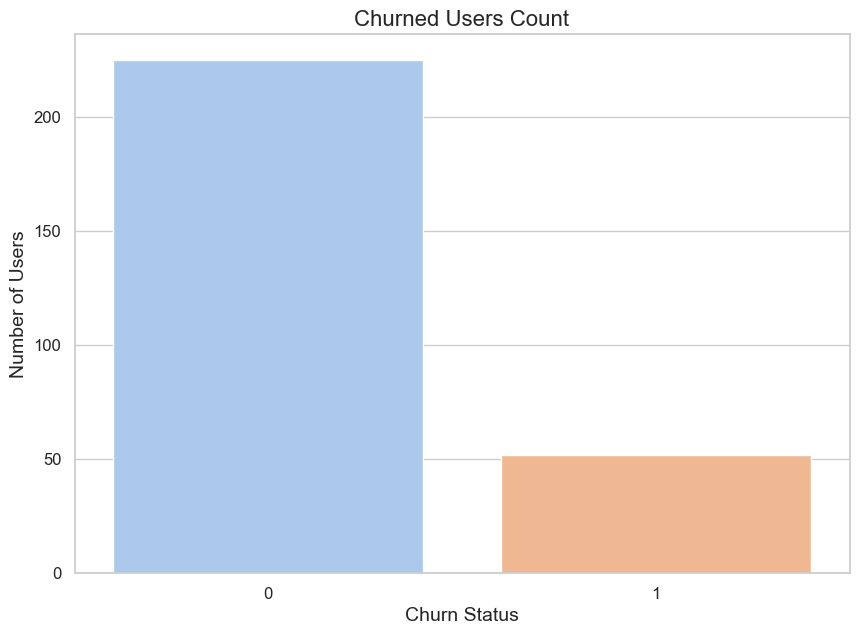

In [70]:
# Plotting the number of users that churned with different style
plt.figure(figsize=[10, 7])
sns.set(style="whitegrid") 
ax = sns.barplot(data=df_churn, x='churn', y='count', palette="pastel")  
plt.title("Churned Users Count", fontsize=16)  
plt.xlabel("Churn Status", fontsize=14) 
plt.ylabel("Number of Users", fontsize=14)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)  
plt.show()  


<strong> 52/(225 + 52) * 100 = 18.772563176895307</strong> <br />
As shown above, 225 users stayed and 52 users churned. Hence, ~18% of the users churned causing imbalance.

#### Number of Users That Churned by Gender

In [24]:
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|  104|
|     F|    1|   20|
|     M|    0|  121|
+------+-----+-----+



In [25]:
df_gender = df_gender.toPandas()
df_gender = df_gender.sort_values('count', ascending = False)

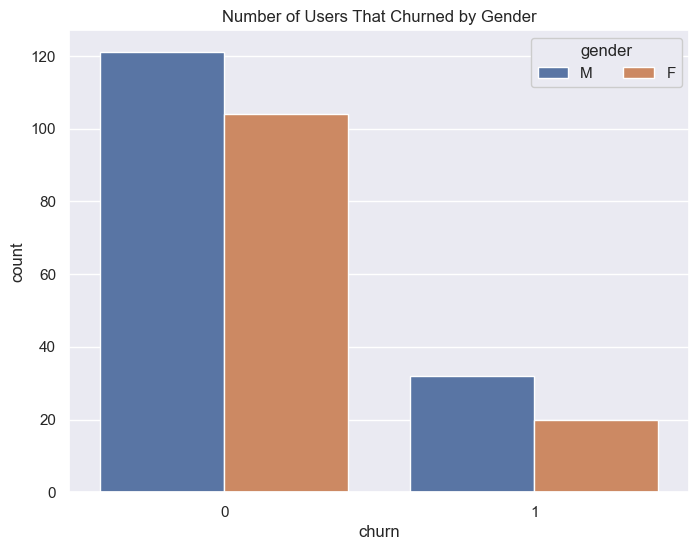

In [26]:
# seaborn barplot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users That Churned by Gender");

<strong>[MALE] 32/(121+32) = 0.20915032679738563</strong><br />
<strong>[FEMALE] 20/(104+20) =0.16129032258064516 </strong><br />
As shown above, we can see that more male users churned compared to the female users.



### Number of Users That Churned by Subscription Level

In [27]:
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

In [28]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|    0|  165|
| free|    0|  195|
| paid|    1|   31|
| free|    1|   21|
+-----+-----+-----+



In [29]:
df_level = df_level.toPandas()

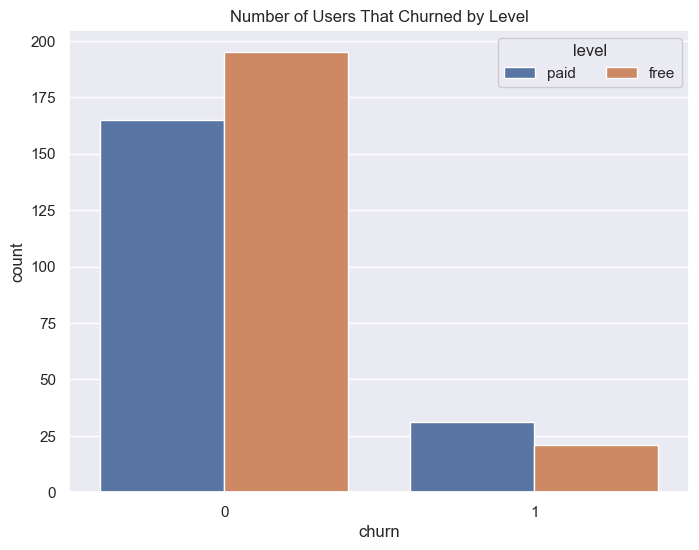

In [30]:
# plot the barplot using seaborn
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_level, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Number of Users That Churned by Level");

<strong>[PAID] 31/(31+165) = 0.15816326530612246</strong><br />
<strong>[FREE] 21/(21+195) = 0.09722222222222222 </strong><br />
The chart above shows that more users who used the services for free were more likely to churn in comparison with the premier users of the app.

# Feature Engineering

After conducting Exploratory Data Analysis (EDA), we've identified promising features to train our model. These features fall into two categories: **Categorical** and **Numerical**.

**Categorical Features:**
- Gender
- Level

**Numerical Features:**
- Number of songs per session
- Number of rollads actions
- Number of thumb down actions
- Number of thumbs up actions
- Number of friends added
- Number of songs added to playlist
- Number of different artists listened to on Sparkify
- Number of days since registering

We will also include a **churn label** and combine all these features into a single DataFrame. Each row in this DataFrame represents user-specific information. After dropping the `userId` column, this DataFrame can be vectorized, standardized, and input into our machine learning algorithms.

To prepare the categorical variables for our model, we will convert them into numeric variables. This step is essential for further processing and training our machine learning algorithms effectively.


#### Gender

In [31]:
gender_f1 = df.select(['userId', 'gender']).dropDuplicates()
gender_f1 = gender_f1.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

#### Level

In [32]:
df2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
df2 = df2.withColumn("Rank", dense_rank().over(w))

In [33]:
level_f2 = df2.filter(df2.Rank == 1).drop(df2.Rank)
level_f2 = level_f2.drop('ts')
level_f2 = level_f2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

#### Number of Songs per Session

In [34]:
song_f3 = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()
df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show(2)
song_f3 = song_f3.groupby('userId').agg({"count":"avg"})
song_f3 = song_f3.withColumnRenamed("avg(count)", "avg_song")

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



#### Number of Rollads Actions

In [35]:
rollad_f4 = df.select(["userId", "page"])
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
rollad_f4 = rollad_f4.withColumn("rollad", rollad_event("page"))
rollad_f4 = rollad_f4.groupby('userId').sum("rollad")
rollad_f4 = rollad_f4.withColumnRenamed("sum(rollad)", "roll_ad")

#### Number of Thumbs Down Actions

In [36]:
thumbdown_f5 = df.select(["userId", "page"])
thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
thumbdown_f5 = thumbdown_f5.withColumn("Thumbs Down", thumddown_event("page"))
thumbdown_f5 = thumbdown_f5.groupby('userId').sum("Thumbs Down")
thumbdown_f5 = thumbdown_f5.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

#### Number of Thumbs Up Actions

In [37]:
thumbup_f6 = df.select(["userId", "page"])
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
thumbup_f6 = thumbup_f6.withColumn("Thumbs Up", thumbup_event("page"))
thumbup_f6 = thumbup_f6.groupby('userId').sum("Thumbs Up")
thumbup_f6 = thumbup_f6.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

#### Number of Friends Added

In [38]:
friend_f7 = df.select(["userId", "page"])
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
friend_f7 = friend_f7.withColumn("add_friend", add_friend("page"))
friend_f7 = friend_f7.groupby('userId').sum("add_friend")
friend_f7 = friend_f7.withColumnRenamed("sum(add_friend)", "add_friend")

#### Number of Songs Added to Playlists

In [39]:
playlist_f8 = df.select(["userId", "page"])
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
playlist_f8 = playlist_f8.withColumn("Playlist", add_playlist("page"))
playlist_f8 = playlist_f8.groupby('userId').sum("Playlist")
playlist_f8 = playlist_f8.withColumnRenamed("sum(Playlist)", "playlist")

#### Number of Listened Artists

In [40]:
artists_f9 = df.select("userId", "artist").dropDuplicates().groupby("userId").count()
artists_f9 = artists_f9.withColumnRenamed("count", "num_artists")

#### Number of Days Since Signing Up

In [41]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
df_days = df_days.withColumn("Rank", dense_rank().over(w))
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))
days_f10 = df_days.drop('registration', 'ts', 'churn', 'delta_days')

#### Churn Label 

In [42]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()
label = label.drop('count')
label = label.withColumnRenamed("churn", "label")

### Create the Features Dataset
After retrieving our features and label, we need to join all features together in one dataframe called `feature_df`.

In [43]:
feature_df = gender_f1.join(level_f2, ["userId"]).join(song_f3, ["userId"]).join(rollad_f4, ["userId"]).join(thumbdown_f5, ["userId"]).join(thumbup_f6, ["userId"]).join(friend_f7, ["userId"]).join(playlist_f8, ["userId"]).join(artists_f9, ["userId"]).join(days_f10, ["userId"]).join(label, ["userId"])

Now we can remove the `user_id` since it will not be used while modeling.

In [44]:
feature_df = feature_df.drop('userId')

In [45]:
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|        253|  55.6436574074074|    0|
|     0|    1|              64.5|      7|          6|       21|         4|       8|        340| 70.07462962962963|    0|
|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    0|
|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    1|
|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    0|
|     0|    0|               8.0

In [80]:
feature_pandas = feature_df.toPandas()
feature_pandas

,gender,level,avg_song,roll_ad,thumbs_down,thumbs_up,add_friend,playlist,num_artists,days,label,vec_features,features
0,1.0,0.0,39.285713,52.0,5.0,17.0,4.0,7.0,253.0,55.643658,0.0,"[1.0, 0.0, 39.28571319580078, 52.0, 5.0, 17.0,...","[2.0088513810055093, 0.0, 0.9178929303893946, ..."
1,0.0,1.0,64.500000,7.0,6.0,21.0,4.0,8.0,340.0,70.074631,0.0,"[0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340...","[0.0, 2.068471556671507, 1.507013343885131, 0...."
2,0.0,0.0,8.000000,1.0,0.0,0.0,0.0,0.0,9.0,71.316887,0.0,"(0.0, 0.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 9.0, ...","(0.0, 0.0, 0.18691638373769065, 0.046445734090..."
3,0.0,0.0,8.000000,1.0,0.0,0.0,0.0,0.0,9.0,71.316887,1.0,"(0.0, 0.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 9.0, ...","(0.0, 0.0, 0.18691638373769065, 0.046445734090..."
4,0.0,0.0,8.000000,1.0,0.0,0.0,0.0,0.0,9.0,71.316887,0.0,"(0.0, 0.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 9.0, ...","(0.0, 0.0, 0.18691638373769065, 0.046445734090..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.0,0.0,35.333332,15.0,2.0,13.0,3.0,4.0,197.0,56.863831,0.0,"[0.0, 0.0, 35.33333206176758, 15.0, 2.0, 13.0,...","[0.0, 0.0, 0.8255473317985746, 0.6966860113561..."
275,1.0,0.0,30.583334,22.0,4.0,11.0,9.0,13.0,327.0,58.538692,0.0,"[1.0, 0.0, 30.58333396911621, 22.0, 4.0, 11.0,...","[2.0088513810055093, 0.0, 0.7145657735186595, ..."
276,1.0,1.0,62.875000,37.0,3.0,27.0,9.0,12.0,424.0,75.447105,0.0,"[1.0, 1.0, 62.875, 37.0, 3.0, 27.0, 9.0, 12.0,...","[2.0088513810055093, 2.068471556671507, 1.4690..."
277,1.0,1.0,98.933334,13.0,13.0,67.0,22.0,43.0,1058.0,81.083183,0.0,"[1.0, 1.0, 98.93333435058594, 13.0, 13.0, 67.0...","[2.0088513810055093, 2.068471556671507, 2.3115..."


In [46]:
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: integer (nullable = true)



In the following cell, we need to convert/cast all features to a float data types in order to be used in the model.

In [47]:
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

### Feature Vector Assembly
In this step, we create a feature vector by assembling selected features into a single vector for machine learning processing. The `VectorAssembler` class from Apache Spark's MLlib is utilized for this purpose.

The VectorAssembler is used to combine features like gender, level, average song count, roll ad actions, thumbs down actions, thumbs up actions, friend additions, playlist additions, number of artists listened to, and days since registering into a single feature vector column named "vec_features". The resulting DataFrame, feature_df, now contains this consolidated feature vector for each row.

This step is crucial for preparing our data for machine learning models, as it consolidates all relevant features into a single format that can be used for training and prediction.

In [48]:
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"], outputCol = "vec_features")
feature_df = assembler.transform(feature_df)
feature_df.show()

+------+-----+---------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
|gender|level| avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|     days|label|        vec_features|
+------+-----+---------+-------+-----------+---------+----------+--------+-----------+---------+-----+--------------------+
|   1.0|  0.0|39.285713|   52.0|        5.0|     17.0|       4.0|     7.0|      253.0|55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|    7.0|        6.0|     21.0|       4.0|     8.0|      340.0| 70.07463|  0.0|[0.0,1.0,64.5,7.0...|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|       0.0|     0.0|        9.0| 71.31689|  0.0|(10,[2,3,8,9],[8....|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|       0.0|     0.0|        9.0| 71.31689|  1.0|(10,[2,3,8,9],[8....|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|       0.0|     0.0|        9.0| 71.31689|  0.0|(10,[2,3,8,9],[8....|
|   0.0|

## Feature Scaling with StandardScaler

In the provided code snippet, the `StandardScaler` from Apache Spark's MLlib is utilized to perform feature scaling on the `vec_features` column in the `feature_df` DataFrame. Feature scaling is a crucial preprocessing step in machine learning to ensure that all features have a similar scale, preventing certain features from dominating others during model training.

Here's what each part of the code does:
- The `StandardScaler` is configured with `inputCol="vec_features"` and `outputCol="features"`, indicating the input and output columns for the scaling operation.
- The `withStd=True` parameter specifies that scaling should be done to unit standard deviation.
- The `scaler_model` is created by fitting the `StandardScaler` to the `feature_df` data, learning the scaling parameters from the input data.
- The original `feature_df` is transformed using the learned scaling parameters, and the scaled features are stored in a new column called "features."
- `feature_df.head(2)` is used to display the first two rows of the DataFrame after the scaling operation, providing a glimpse into how the scaled features appear in the transformed dataset.

By scaling the features, we ensure that they have comparable ranges, leading to improved model performance and accurate predictions.


In [49]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)
scaler_model = scaler.fit(feature_df)
feature_df = scaler_model.transform(feature_df)
feature_df.head(2)

[Row(gender=1.0, level=0.0, avg_song=39.28571319580078, roll_ad=52.0, thumbs_down=5.0, thumbs_up=17.0, add_friend=4.0, playlist=7.0, num_artists=253.0, days=55.64365768432617, label=0.0, vec_features=DenseVector([1.0, 0.0, 39.2857, 52.0, 5.0, 17.0, 4.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0089, 0.0, 0.9179, 2.4152, 0.4025, 0.2749, 0.207, 0.2256, 0.434, 1.4531])),
 Row(gender=0.0, level=1.0, avg_song=64.5, roll_ad=7.0, thumbs_down=6.0, thumbs_up=21.0, add_friend=4.0, playlist=8.0, num_artists=340.0, days=70.07463073730469, label=0.0, vec_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), features=DenseVector([0.0, 2.0685, 1.507, 0.3251, 0.483, 0.3396, 0.207, 0.2579, 0.5832, 1.8299]))]

#### Data Splitting
Now we split the data into three parts form modeling. We will use 60% for training, 20% for validation, and 20% for testing.

In [50]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 1996)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:167
Test Dataset:58
Validation Dataset:54


## Modelling and Model Evaluation

In this phase of our analysis, we focus on constructing and evaluating predictive models using the prepared numeric features in our DataFrame. The dataset, now containing only numeric variables, is ready for model training. We will divide this dataset into training, testing, and validation sets. Several machine learning classification algorithms will be explored, including:

### 1. Logistic Regression
Logistic Regression is chosen for its reliability in binary classification problems. It provides good explainability, ease of implementation, and efficiency in training. Its interpretability makes it a valuable choice for understanding the factors contributing to churn.

### 2. Random Forest Classifier
Random Forest, an ensemble learning method, constructs multiple decision trees and combines their predictions via majority voting. This technique mitigates overfitting and demonstrates robust performance, especially on imbalanced datasets like ours.

### 3. Gradient-Boosted Tree Classifier
Gradient-Boosted Tree (GBT) Classifier builds trees sequentially, each correcting errors made by the previous ones. While there's a risk of overfitting, GBT performs well on unbalanced datasets. Its ability to address the shortcomings of individual trees enhances predictive accuracy.

### 4. Linear Support Vector Machine (Linear SVC)
Linear Support Vector Machine (Linear SVC) is a binary classification algorithm that works efficiently when there are clear margins of separation between classes. It is memory-efficient and well-suited for our problem.

### 5. Naive Bayes
Naive Bayes is a probabilistic classifier that's easy to implement and computationally fast. Despite its simplicity, it often performs surprisingly well and serves as a baseline model for comparison.

**Model Training and Evaluation Process:**
1. **Instantiate Models:** Create instances of each model.
2. **Fit Models on Training Data:** Train the models using the training set.
3. **Prediction:** Use the trained models to make predictions on the test data.
4. **Evaluation:** Assess the models' performance using various metrics, including accuracy and F1-score. F1-score, being a balance between precision and recall, is particularly useful for evaluating binary classification models, especially when dealing with imbalanced classes.

Once the models are trained and evaluated, the one demonstrating the best F1-score, accuracy, and computational efficiency will be selected.


In [51]:
# Instantiating Machine Learning Models with Seed for Reproducibility

# Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, seed=42)

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label', seed=1996)

# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(featuresCol='features', labelCol='label', maxIter=10, seed=1996)

# Linear Support Vector Machine
lsvc = LinearSVC(featuresCol='features', labelCol='label')

# Naive Bayes
nb = NaiveBayes(featuresCol='features', labelCol='label')

# Creating a list of models
model_list = [lr, rf, gbt, lsvc, nb]


In [52]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [53]:
# Improved Model Training and Evaluation Loop

# Setting up logging configuration
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Loop through all models for training and evaluation
for model in model_list:
    model_name = model.__class__.__name__  # Get model name
    
    # Logging: Training started
    logging.info(f'Training {model_name} started')
    
    # Start time
    start_time = time.time()
    
    # Train the model on the training dataset
    model = model.fit(train)
    
    # End time
    end_time = time.time()
    
    # Logging: Training ended
    logging.info(f'Training {model_name} ended')
    
    # Logging: Time taken for training
    logging.info(f'Time taken for {model_name}: {(end_time - start_time):.2f} seconds')
    
    # Logging: Prediction started
    logging.info(f'{model_name} predicting started')
    
    # Make predictions on the validation dataset
    predictions = model.transform(valid)
    
    # Logging: Prediction ended
    logging.info(f'{model_name} predicting ended')
    
    # Evaluate model performance
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / predictions.count()
    
    # Logging: F1 Score and Accuracy
    logging.info(f'F1 Score for {model_name}: {f1_score:.4f}')
    logging.info(f'Accuracy for {model_name}: {accuracy:.4f}')

LogisticRegression training started


LogisticRegression training ended
Time taken for LogisticRegression is: 246.10554933547974 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.6272141706924317
The accuracy of the LogisticRegression model is: 0.7037037037037037
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 298.1521759033203 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.6174196174196175
The accuracy of the RandomForestClassifier model is: 0.6851851851851852
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 120.3205668926239 seconds
GBTClassifier predicting started
GBTClassifier predicting ended
F1 for GBTClassifier is: 0.6045728603868138
The accuracy of the GBTClassifier model is: 0.6296296296296297
LinearSVC training started
LinearSVC training ended
Time taken for 

In [74]:
# Compute accuracy and F1 score for the predictions
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print evaluation metrics
print(f'Accuracy[BEST]: {accuracy:.4f}')
print(f'F1 Score[BEST]: {f1_score:.4f}')

Accuracy[BEST]: 0.7593
F1 Score[BEST]: 0.6554


# Conclusion

### Dataset Exploration and Feature Engineering

At the beginning of the project, we tackled a challenging task: working with a modest dataset of 128MB and only 225 unique customers. After loading and cleaning the data, we delved into exploring the dataset to identify crucial features that could predict churn. Through rigorous analysis, we identified the most promising features and proceeded to preprocess them meticulously.

### Machine Learning Algorithms and Model Tuning

We applied various machine learning algorithms to our preprocessed features, aiming to identify the most effective predictor of churn. After thorough experimentation, the LinearSVC algorithm emerged as the top performer. 

### Business Impact and Future Strategies

##### Targeted Customer Engagement

This project equips Sparkify with actionable insights. By identifying customers prone to churn, Sparkify can strategically intervene by offering enticing incentives. This approach not only retains customers but also preserves Sparkify's revenue streams. Notably, our findings indicate that newer customers are particularly susceptible to churn. Consequently, targeted initiatives such as a free trial of the premium service, devoid of advertisements, could be an effective retention strategy.

#### Enhanced Music Recommendation System

Additionally, we propose enhancing Sparkify's music recommendation system. By leveraging our understanding of user interactions, we can refine song recommendations. By suggesting songs aligned with users' preferences, Sparkify can enhance user satisfaction, reducing the likelihood of negative feedback (e.g., thumbs down). This targeted approach promotes a more engaging user experience and fosters customer loyalty.

### Project Reflection

##### Technical Proficiency and Learning

This project served as an invaluable learning experience. Working with Spark, particularly in manipulating datasets and engineering features, provided hands-on exposure to big data analytics. Utilizing Spark MLib for machine learning model development enhanced our proficiency in predictive analytics. Notably, building a churn prediction model in PySpark presented a distinctive challenge, diverging from conventional methods employed with tools like pandas.


In summary, this project not only yielded actionable outcomes for Sparkify but also significantly enriched our understanding of data science techniques in the context of customer churn prediction. The acquired skills and insights pave the way for innovative approaches to business challenges, positioning us for continued success in the dynamic field of data science.
